# Example 3. Analysis pipeline (Using RU-Net and WAC-Net in sequence)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/softmatterlab/Quantitative-Microplankton-Tracker/blob/main/examples/3-example_Analysis.ipynb)

This example demonstrates how to use a pre-trained RU-Net and WAC-Net in sequence to get the dry mass values

**NOTE**:
- If you're using google colaboratory to run this notebook, please uncomment the code in the following cell to clone the repository.
- If you're running the notebook on your local machine, please skip this step to avoid cloing the repository in the current folder.

In [1]:
# !git clone https://github.com/softmatterlab/Quantitative-Microplankton-Tracker.git
# %cd Quantitative-Microplankton-Tracker/examples/

In [2]:
%matplotlib inline
import sys
sys.path.append("..")

## 1. Setup
Import the dependencies to run this tutorial. 

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.measure import label, regionprops
import deeptrack as dt

## 2. Load experimental holographic image
We use a 50 frame experimental image sequence containing species in this tutorial. Experimental images are located in ```sample-data``` folder.

In [4]:
exp_data = np.load(
    "../data/data_figure2/Oxyrrhis_data.npy"
)
np.shape(exp_data)

(50, 1024, 1280)

### 2.1. Visualize experimental image
First frame of the experimental holographic sequence

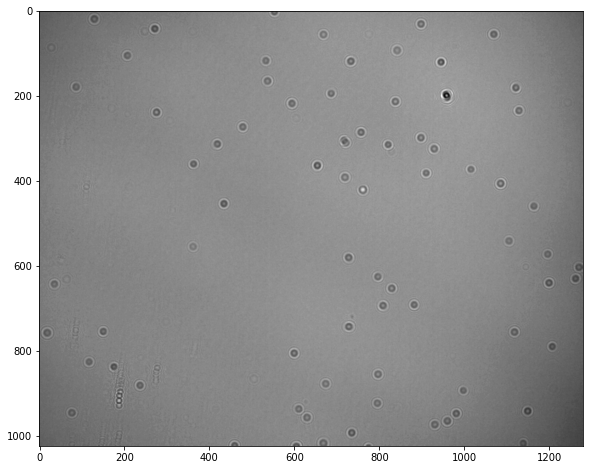

In [5]:
plt.figure(figsize=(12, 8))
plt.imshow(exp_data[0], cmap="gray")
plt.show()

## 3. RU-Net prediction on experimental images
We use RU-Net model to segment planktons from the background, and to extract their properties. Pre-trained models are located in ```pre-trained models``` folder
### 3.1. Load pre-trained RU-Net model

In [6]:
RUNet_model = tf.keras.models.load_model(
    "../pre-trained-models/RUNet.h5",
    compile=False
)

### 3.2. Predictions followed by extracting properties
```predict_image``` function extracts the 2d positions, dry mass and z-distance from predictions of RU-Net

In [7]:
def predict_image(predicted_image, threshold):
    """
    Outputs the predicted channels for regression U-nets
    Inputs: image and image threshold, Eg., 0.1
    Outputs: xpositions, ypositions, zpositions, drymass, and eccentricity
    """
    Data = []

    X, Y = np.meshgrid(
        range(0, predicted_image.shape[2]), range(0, predicted_image.shape[1])
    )
    X = np.reshape(X, (predicted_image.shape[1] * predicted_image.shape[2]))
    Y = np.reshape(Y, (predicted_image.shape[1] * predicted_image.shape[2]))

    for i in range(predicted_image.shape[0]):

        zpos = []
        mass = []
        xpos = []
        ypos = []
        ecc = []
        xyri = []

        predX = predicted_image[i, :, :, 3]
        predY = predicted_image[i, :, :, 4]

        gx1, gy1 = np.gradient(predX)
        gx2, gy2 = np.gradient(predY)

        I = gy1 + gx2

        I2 = np.zeros(I.shape)
        I2[I > threshold] = 1

        I3 = label(I2)
        prop = regionprops(I3)

        zs = predicted_image[i, :, :, 1]
        masses = predicted_image[i, :, :, 2]
        I3 = np.reshape(
            I3, (predicted_image.shape[2] * predicted_image.shape[1])
        )
        zs = np.reshape(
            zs, (predicted_image.shape[2] * predicted_image.shape[1])
        )
        masses = np.reshape(
            masses, (predicted_image.shape[2] * predicted_image.shape[1])
        )

        for j in range(np.amax(I3)):
            if prop[j].eccentricity < 1.2:

                ecc.append(prop[j].eccentricity)

                inds = np.where(I3 == j + 1)
                zpos.append(np.mean(zs[inds]))
                mass.append(np.mean(masses[inds]))
                xpos.append(np.mean(X[inds]))
                ypos.append(np.mean(Y[inds]))

                xyri.append(
                    [
                        np.mean(X[inds]),
                        np.mean(Y[inds]),
                        np.mean(zs[inds]),
                        np.mean(masses[inds]),
                    ]
                )

        xyri = np.array(xyri)
        Data.append(xyri)

    return Data

### 3.3. Preparing the images for prediction
Split the 50 frame sequence into batches of 5 for prediction

In [8]:
batchsize = 5
data_in_batches = [
    exp_data[i : i + batchsize] for i in range(0, int(len(exp_data)), batchsize)
]

Function to obtain RU-Net predictions on a batch of images

In [9]:
def get_prediction_batch(batch, model):
    '''
    return the prediction of a batch of images
    '''
    batch_reshape = np.expand_dims(batch, axis=3)
    prediction = model.predict(batch_reshape)
    return prediction

### 3.4. Predict positions
Get the positions of planktons from the RU-Net predictions. The positions are stored in ```position_data```. This process should take about a minute.

In [10]:
position_data = []

threshold = 0.1
median_val = np.median(exp_data[0])

for i in tqdm(range(len(data_in_batches)), desc="Predicting batch "):
    batch = data_in_batches[i]

    prediction = get_prediction_batch(
        batch / median_val, 
        RUNet_model
    )

    positions = predict_image(
        prediction, 
        threshold
    )

    for coords in positions:
        position_data.append(coords)

Predicting batch :   0%|          | 0/10 [00:00<?, ?it/s]

### 3.5. Highlight the plankton positions
Change ```frame_no``` to higlight plankton positions in other frames

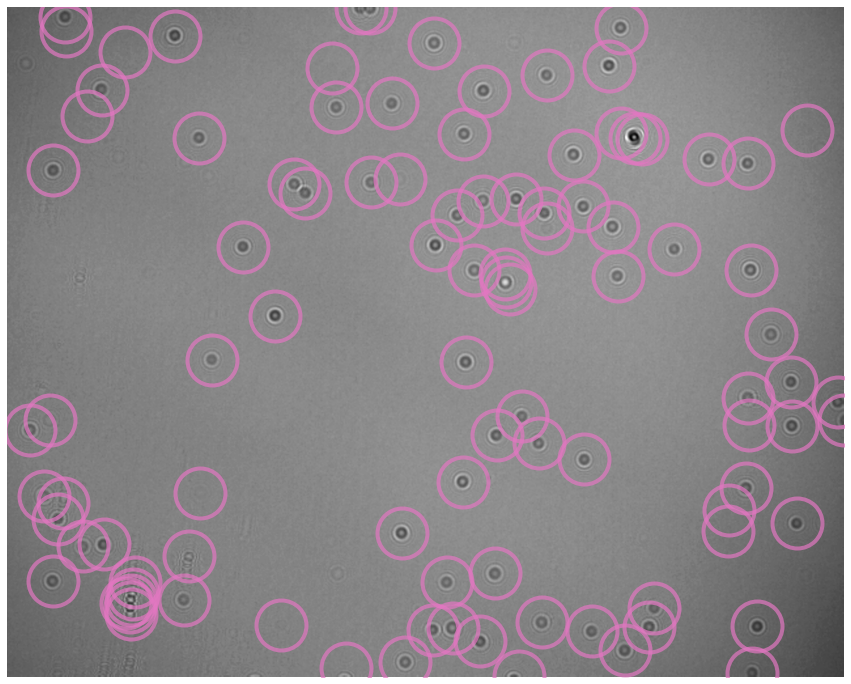

In [11]:
frame_no = 10

fig, ax = plt.subplots(figsize=(15,15))

ax.imshow(exp_data[frame_no], cmap='gray')

X = position_data[frame_no][:, 0]
Y = position_data[frame_no][:, 1]

for i in range(0,len(X),1):
    x0 = X[i]
    y0 = Y[i]
    ax.plot(x0, y0,'o', ms=50, markerfacecolor="None", markeredgecolor="#e377c2", markeredgewidth=4, alpha=0.7)

plt.axis("off")
plt.show()

## 4. Plankton trajectories
### 4.1. Get particle traces
We use ```get_particle_trace``` function to link the plankton positions in all the frames to individual trajectories

In [12]:
particles, completed_traces = dt.get_particle_trace(position_data)
print('Particles', np.shape(particles), 'completed traces', np.shape(completed_traces))
all_traces = completed_traces + particles[0] 
print("Number of particle traces ", len(all_traces))

Particles (1, 110) completed traces (30,)
Number of particle traces  140


### 4.2. Formatting trajectories into a dataframe
Formatting trajectories into dataframes makes it easy to read the trajectories

In [13]:
list_of_dataframes = []

for i in range(len(all_traces)):
    
    df = pd.DataFrame(all_traces[i], columns = ['frame', 'x', 'y', 'z', 'drymass'])
    df = df.assign(particle = [i]*len(all_traces[i]))
    
    list_of_dataframes.append(df)
    
particle_data = pd.concat(list_of_dataframes, ignore_index = True)

particle_data = particle_data[particle_data.x != 0] #deletes all rows where x=0 and y=0, because that's probably some weird prediction at the edge
particle_data = particle_data[particle_data.y != 0]

particle_data

,frame,x,y,z,drymass,particle
0,0,1145.125000,601.875000,-0.054241,0.187524,0
1,1,1144.833333,601.833333,-0.081731,0.178887,0
2,2,1145.000000,602.285714,-0.081766,0.184561,0
3,3,1145.500000,601.500000,-0.061431,0.125581,0
4,4,1145.333333,602.333333,-0.109081,0.147072,0
...,...,...,...,...,...,...
4201,49,1043.500000,783.000000,0.079965,0.048296,135
4202,49,230.000000,838.500000,0.121690,0.077743,136
4203,49,10.200000,861.400000,0.190252,0.102897,137
4204,49,565.000000,1013.250000,0.169295,0.102271,138


### 4.3. Process trajectories
Trajectories are processed and relevant information is stored in ```traj_data```

In [14]:
trajs = []
trajs_lengths = []

positions=particle_data.set_index(['particle', 'frame'])[['x', 'y']].unstack()

for index, rows in positions.iterrows():
    traj_len=np.count_nonzero(~np.isnan(rows[['x', 'y'][0]]))

    trajs_lengths.append(traj_len)
    trajs.append(np.transpose([rows[['x','y'][0]].to_numpy(), rows[['x', 'y'][1]].to_numpy()]))

In [15]:
# Appending the frame number before the nodes
traj_data = []
for i in range(len(trajs)):
    non_nan_indices = np.where(np.isnan(trajs[i][:,0]) == False)[0]
    frame_no = np.reshape(non_nan_indices, (len(non_nan_indices),1))
    frame_and_centroids = np.append(frame_no, trajs[i][non_nan_indices], axis=1)
    traj_data.append(frame_and_centroids)

### 4.4. Visualize the trajectories
Trajectories are plotted over the final frame of the sequence for easy visualization. The index of the trajectory helps to isloate individual single plankton traces

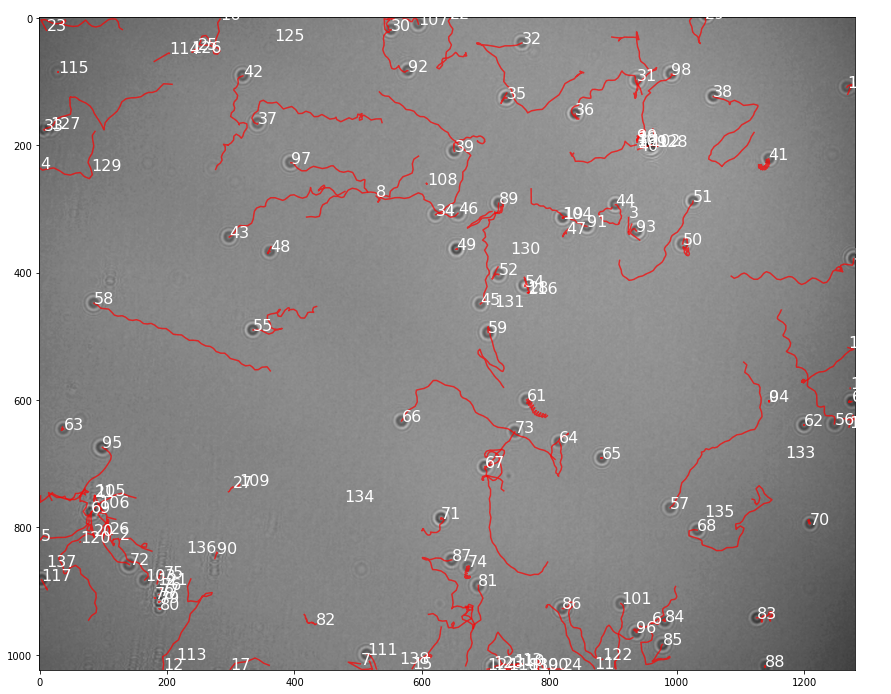

In [16]:
fig, ax=plt.subplots(figsize=(18, 12))
ax.imshow(exp_data[-1], cmap="gray")
i = 0
for trajectory in traj_data:
    ax.plot(trajectory[:,1], trajectory[:,2], "red", alpha=0.7, linewidth=1.5)
    ax.text(trajectory[:,1][-1], trajectory[:,2][-1], str(i), color="white", fontsize=16)
    i += 1


## 5. Dry mass prediction by WAC-Net
We now crop 64 x 64 pixel images around the single plankton traces, and predict a improved dry mass values with a pre-trained WAC-Net.

### 5.1. Selecting planktons
Pick a plankton trace by their ```number``` in the above figure for the dry mass prediction. Alternatively, dry mass can also be predicted for all the planktons

In [17]:
trace_no = 58

Function to obtain the crop around the plankton position

In [18]:
def croppedimage(image, position, window=32):
    """
    crops a region of 2*window pixels around the position
    """
    [a, b, c, d] = [
        int(position[0] - window),
        int(position[0] + window),
        int(position[1] - window),
        int(position[1] + window),
    ]
    return image[c:d, a:b]

### 5.2. Obtaining sequence of crops for a single plankton trajectory
Crops are stored in ```cropped_sequence```

In [19]:
cropped_sequence = []
single_plankton_traj = traj_data[trace_no]

for i in range(len(single_plankton_traj)):

    crop = croppedimage(
        exp_data[
            int(single_plankton_traj[i][0])
            ], 
        single_plankton_traj[i][1:3]
    )

    cropped_sequence.append(crop)

Visuazlise first frame in the cropped plankton sequence

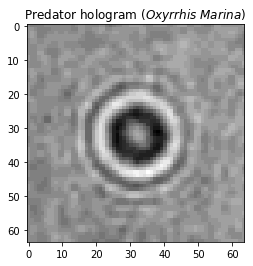

In [20]:
plt.imshow(cropped_sequence[0], cmap="gray")
plt.title("Predator hologram ($\it{Oxyrrhis\ Marina}$)")
plt.show()

### 5.3. Load pre-trained WAC-Net model for dry mass model
We define the WAC-Net model and load the weights from a pre-trained model. 

In [21]:
from tensorflow import keras

Sequential = keras.models.Sequential
Model = keras.models.Model
Dense = keras.layers.Dense
Conv = keras.layers.Conv2D
Conv1D = keras.layers.Conv1D
ConvL = keras.layers.LocallyConnected2D
Pool = keras.layers.MaxPooling2D
Input = keras.layers.Input
Concat = keras.layers.Concatenate
TimeDistributed = keras.layers.TimeDistributed
Flatten = keras.layers.Flatten
Lambda = keras.layers.Lambda
K = keras.backend


model = Sequential()
model.add(
    (
        Conv(
            32,
            kernel_size=3,
            strides=1,
            activation="relu",
            input_shape=(64, 64, 1),
        )
    )
)
model.add(Pool(2))
model.add((Conv(64, kernel_size=3, strides=1, activation="relu")))
model.add(Pool(2))
model.add((Conv(128, kernel_size=3, strides=1, activation="relu")))
model.add(Pool(2))
model.add((Conv(256, kernel_size=3, strides=1, activation="relu")))
model.add((Flatten()))
model.add((Dense(128, activation="relu")))
model.add((Dense(128, activation="relu")))

stack = Input(model.input_shape)
vectors = TimeDistributed(model)(
    stack
)  # time distributed applies a layer to every temporal slice of the input
weights = Conv1D(128, 1, padding="same")(vectors)
weights = Conv1D(128, 1, padding="same")(weights)
weights = Conv1D(1, 1, padding="same")(weights)


def merge_function(tensors):
    x = tensors[0]
    weights = tensors[1]
    weights = K.softmax(weights, axis=1)
    merged = K.sum(x * weights, axis=1)
    return merged


merge_layer = Lambda(merge_function)

merged = merge_layer([vectors, weights])

merged = Dense(32, activation="relu")(merged)
merged = Dense(32, activation="relu")(merged)
out = Dense(2)(merged)
model = Model(stack, out)

model.compile(tf.keras.optimizers.Adam(lr=0.0001, amsgrad=True), loss="mae")
model.load_weights("../pre-trained-models/WACNet_dry_mass.h5")

### 5.4. Normalise the crops
Normalise and reshape the images for WAC-Net prediction

In [22]:
def Normalise(images, batch = 15):
    Normalised = []
    for i in range(len(images)):
        Normalised.append(images[i]/np.median(images[i]))
    Normalised = np.array(Normalised)-1
    proc = []
    
    #sliding window
    for i in range(len(Normalised)-batch+1):
        proc.append(Normalised[i:i+batch])
    return np.expand_dims(proc, axis = -1)

In [23]:
# Funtion to convert the predicted dry mass to real dry mass units (pico grams)
def real_dm(p, a=209.16, b=0.28, sp_ri_inc = 0.21):
    return (p*a+b)/sp_ri_inc

### 5.5. Prediction on cropped sequences
Experimental sequences are normalized with ```batch``` size of 15. ```batch``` value can be increased or decreased to generate a sliding window of the experimental sequence. The WAC-Net assigns weights to the images with in sliding windows to predict the best possible value for dry mass considering all the frames in a sliding window.

In [25]:
prediction = model.predict(
    Normalise(
        cropped_sequence,
        batch = 15
    )
)

### 5.6. Conver valus to dry mass units

In [26]:
drymass_prediction = real_dm(prediction[:,0])

### 5.7. Visualize dry mass predictions

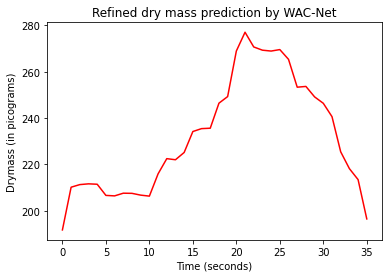

In [27]:
plt.title("Refined dry mass prediction by WAC-Net")
plt.plot(drymass_prediction, "red")
plt.xlabel('Time (seconds)')
plt.ylabel('Drymass (in picograms)')
xticks = np.arange(0,550,50)
ax.set_xticks(xticks)
ax.set_xticklabels([int(x*(1/10)) for x in xticks])
plt.show()